1. Сбор исходных данных
Исходные данные:
             Alkane_Name         SMILES  Refractive_Index_Exp
0  2,2,3-Trimethylbutane  CC(C)(C)C(C)C                1.3894
1                Propane            CCC                1.2898
2            Butane (n-)           CCCC                1.3326
3              Isobutane         CC(C)C                1.3518
4           Pentane (n-)          CCCCC                1.3575
Всего молекул в наборе данных: 28
2. Генерация молекулярных дескрипторов из SMILES

Данные с сгенерированными дескрипторами:
             Alkane_Name         SMILES  Refractive_Index_Exp    MolWt  \
0  2,2,3-Trimethylbutane  CC(C)(C)C(C)C                1.3894  100.205   
1                Propane            CCC                1.2898   44.097   
2            Butane (n-)           CCCC                1.3326   58.124   
3              Isobutane         CC(C)C                1.3518   58.124   
4           Pentane (n-)          CCCCC                1.3575   72.151   

   HeavyAtomCount

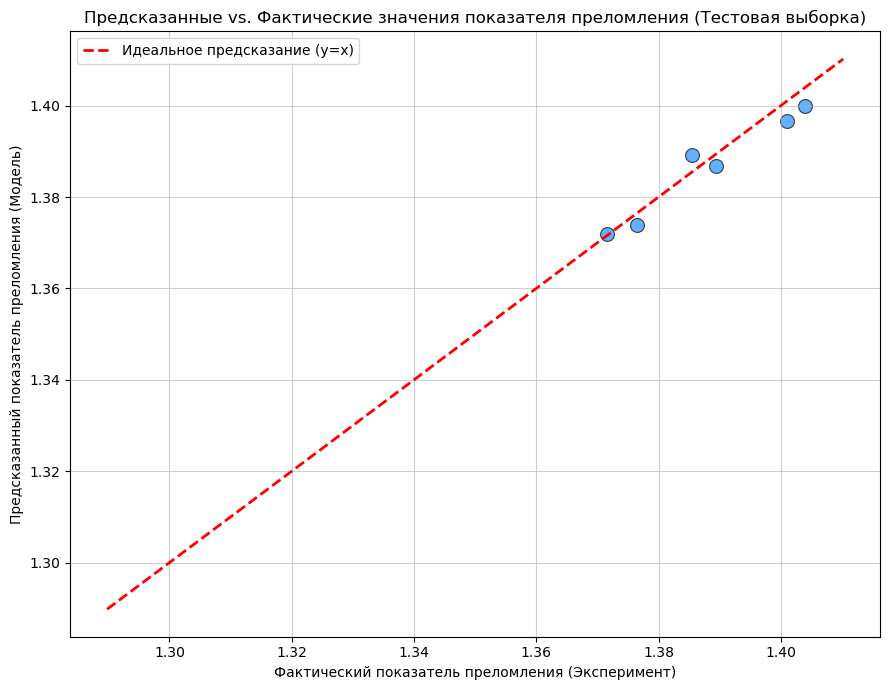

6. Анализ важности дескрипторов

Топ-5 наиболее влиятельных дескрипторов:
                Feature  Importance
0                 MolWt    0.190153
4                Kappa1    0.141665
10  NumValenceElectrons    0.133171
1        HeavyAtomCount    0.125237
7                   Ipc    0.119146


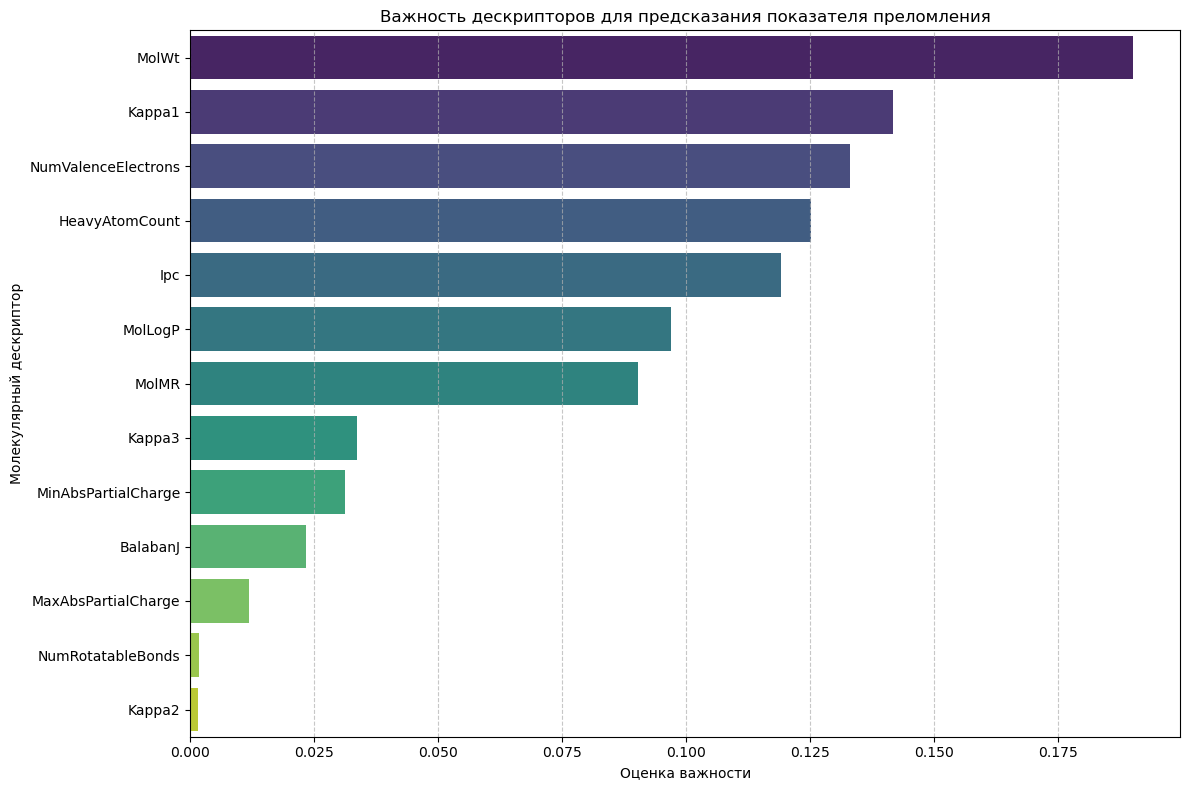

7. Предсказание показателя преломления для гипотетической молекулы

Предсказание для 'n-Dodecane (Hypothetical)' (SMILES: 'CCCCCCCCCCCC'):
  Предсказанный показатель преломления: 1.4088
Показатель преломления по методу Гладстона Дейла: 1.419
Экспериментальный показатель преломления: 1.421


In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("1. Сбор исходных данных")
excel_file_path = 'experimental data.xlsx' 
df = pd.DataFrame(pd.read_excel(excel_file_path, sheet_name='Alkanes'))
df['Refractive_Index_Exp'] = df['Refractive_Index_Exp'].astype(str)
df['Refractive_Index_Exp'] = df['Refractive_Index_Exp'].str.replace(',', '.')
df['Refractive_Index_Exp'] = df['Refractive_Index_Exp'].str.strip()
df['Refractive_Index_Exp'] = df['Refractive_Index_Exp'].str.replace('\xa0', '', regex=True)
df['Refractive_Index_Exp'] = pd.to_numeric(df['Refractive_Index_Exp'], errors='coerce')
initial_len = len(df)
df = df.dropna(subset=['Refractive_Index_Exp'])
if len(df) < initial_len:
    print(f"Удалено {initial_len - len(df)} строк, где нет значения показателя преломления.")
print("Исходные данные:")
print(df.head())
print(f"Всего молекул в наборе данных: {len(df)}")

print("2. Генерация молекулярных дескрипторов из SMILES")
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)
if df['Mol'].isnull().any():
    print("Некоторые SMILES не были корректно преобразованы в объекты Mol. Проверьте исходные SMILES.")
    df = df.dropna(subset=['Mol'])
    print(f"После очистки осталось молекул: {len(df)}")
selected_descriptor_funcs = [
    Descriptors.MolWt,
    Descriptors.HeavyAtomCount,
    Descriptors.NumRotatableBonds,
    Descriptors.BalabanJ,
    Descriptors.Kappa1,
    Descriptors.Kappa2,
    Descriptors.Kappa3,
    Descriptors.FractionCSP3,
    Descriptors.HallKierAlpha,
    Descriptors.Ipc,
    Descriptors.PEOE_VSA1,
    Descriptors.PEOE_VSA2,
    Descriptors.PEOE_VSA3,
    Descriptors.MolLogP,
    Descriptors.MolMR,
    Descriptors.NumValenceElectrons,
    Descriptors.MaxAbsPartialCharge,
    Descriptors.MinAbsPartialCharge,
]
descriptor_names = [
    'MolWt', 'HeavyAtomCount', 'NumRotatableBonds', 'BalabanJ',
    'Kappa1', 'Kappa2', 'Kappa3', 'FractionCSP3', 'HallKierAlpha', 'Ipc',
    'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3', 'MolLogP', 'MolMR',
    'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge'
]
descriptor_list = []
for mol in df['Mol']:
    try:
        AllChem.ComputeGasteigerCharges(mol)
        desc_values = [func(mol) for func in selected_descriptor_funcs]
        descriptor_list.append(desc_values)
    except Exception as e:
        print(f"Ошибка при генерации дескрипторов для молекулы: {Chem.MolToSmiles(mol) if mol else 'Неизвестная'} - {e}")
        descriptor_list.append([np.nan] * len(selected_descriptor_funcs))
desc_df = pd.DataFrame(descriptor_list, columns=descriptor_names)
df_final = pd.concat([df.drop('Mol', axis=1), desc_df], axis=1)
print("\nДанные с сгенерированными дескрипторами:")
print(df_final.head())

print("3. Подготовка данных для машинного обучения")
X = df_final[descriptor_names]
y = df_final['Refractive_Index_Exp']
initial_num_features = X.shape[1]
X = X.loc[:, (X != X.iloc[0]).any()]
X = X.dropna(axis=1)
cleaned_num_features = X.shape[1]
if initial_num_features > cleaned_num_features:
    print(f"Удалено {initial_num_features - cleaned_num_features} константных или NaN-дескрипторов")
    print(f"Осталось дескрипторов: {cleaned_num_features}")
if X.empty:
    raise ValueError("После очистки не осталось дескрипторов")
print(f"\nДескрипторы для моделирования:")
print(X.head())
print(f"\nЦелевая переменная:")
print(y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

print("4. Построение и обучение модели RandomForestRegressor")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("5. Оценка производительности модели")
y_pred_test = model.predict(X_test)
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
print(f"  Метрики на тестовой выборке:")
print(f"  R^2 (коэффициент детерминации): {r2:.3f}")
print(f"  RMSE (среднеквадратичная ошибка): {rmse:.5f}")
print(f"  MAE (средняя абсолютная ошибка): {mae:.5f}")
plt.figure(figsize=(9, 7))
sns.scatterplot(x=y_test, y=y_pred_test, s=100, alpha=0.7, color='dodgerblue', edgecolor='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Идеальное предсказание (y=x)')
plt.xlabel('Фактический показатель преломления (Эксперимент)')
plt.ylabel('Предсказанный показатель преломления (Модель)')
plt.title('Предсказанные vs. Фактические значения показателя преломления (Тестовая выборка)')
plt.grid(True, linestyle='-', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print("6. Анализ важности дескрипторов")
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nТоп-5 наиболее влиятельных дескрипторов:")
    print(importance_df.head(5))
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette='viridis', legend=False)
    plt.title('Важность дескрипторов для предсказания показателя преломления')
    plt.xlabel('Оценка важности')
    plt.ylabel('Молекулярный дескриптор')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Модель не поддерживает прямую оценку важности признаков.")

print("7. Предсказание показателя преломления для гипотетической молекулы")
new_alkane_smiles = 'CCCCCCCCCCCC'
new_alkane_name = 'n-Dodecane (Hypothetical)'
new_mol = Chem.MolFromSmiles(new_alkane_smiles)
if new_mol is None:
    print(f"Ошибка: Некорректный SMILES для '{new_alkane_name}'. Невозможно предсказать.")
else:
    try:
        AllChem.ComputeGasteigerCharges(new_mol)
        new_desc_values = [func(new_mol) for func in selected_descriptor_funcs]
        new_desc_df = pd.DataFrame([new_desc_values], columns=descriptor_names)

        new_X_for_prediction = new_desc_df[X.columns]

        predicted_ri = model.predict(new_X_for_prediction)[0]

        print(f"\nПредсказание для '{new_alkane_name}' (SMILES: '{new_alkane_smiles}'):")
        print(f"  Предсказанный показатель преломления: {predicted_ri:.4f}")
        print(f"Показатель преломления по методу Гладстона Дейла: 1.419")
        print(f"Экспериментальный показатель преломления: 1.421")
        
    except Exception as e:
        print(f"Ошибка при предсказании для новой молекулы '{new_alkane_name}': {e}")